<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1">Setup</a></span><ul class="toc-item"><li><span><a href="#Data-Transformations" data-toc-modified-id="Data-Transformations-1.1">Data Transformations</a></span></li><li><span><a href="#Data-Fetching,-Metrics,-Callbacks" data-toc-modified-id="Data-Fetching,-Metrics,-Callbacks-1.2">Data Fetching, Metrics, Callbacks</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-2">Training</a></span><ul class="toc-item"><li><span><a href="#Training-The-Head" data-toc-modified-id="Training-The-Head-2.1">Training The Head</a></span></li><li><span><a href="#Interpret" data-toc-modified-id="Interpret-2.2">Interpret</a></span></li><li><span><a href="#Unfreezing-&amp;-Fine-Tuning" data-toc-modified-id="Unfreezing-&amp;-Fine-Tuning-2.3">Unfreezing &amp; Fine Tuning</a></span></li><li><span><a href="#Interpret" data-toc-modified-id="Interpret-2.4">Interpret</a></span></li></ul></li></ul></div>

<h1> MobileNet V2 Shot-Framing Detector

In this notebook, the goal was to set a baseline -- no extra data augmentations, no `mixup`, no mixed precision  training, and no progressive image resizing was done.

With nothing fancy going on, `MobileNetV2` beat the previous best model -- a ResNet-50, achieving 93.82 accuracy. We're gonna need a tougher validation set going forward.

## Setup

In [ ]:
#export
from fastai.vision import *
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback
from fastai.metrics import accuracy, Precision, Recall

In [ ]:
path = '/home/rahul/github_projects/CinemaNet/'

### Data Transformations

In [ ]:
#export
to_film_ar = lambda h: (h, int(h * 16/9)) # h = height

def xtra_tfms(base_size): 
    box_dim = int(base_size/4)
    cutout_ = partial(cutout, p = .3, n_holes = (1,1), length = (box_dim, box_dim))
    jitter_ = partial(jitter, p = .3,  magnitude = (0.005, 0.01))
    skew_   = partial(skew,   p=.3, direction = (0, 7), magnitude = 0.2)
    squish_ = partial(squish, p=.3, row_pct = 0.25, col_pct = 0.25)
    tilt_   = partial(tilt,   p=.3, direction = (0, 3))
    perp_warp_ = partial(perspective_warp, p=.3, magnitude = (-0.2, 0.2))
    crop_pad_  = partial(crop_pad, p=.3, padding_mode = 'border', row_pct = 0.1, col_pct = 0.1)
    rgb_randomize_ = partial(rgb_randomize, thresh=0.05)
    #dihedral_  = partial(dihedral, ())
    
    xtra_tfms = [jitter_(), skew_(), squish_(), perp_warp_(),
                 tilt_(), cutout_(), crop_pad_()]
    
    return xtra_tfms

def get_tfms(base_size): return get_transforms(do_flip = True,
                                               flip_vert = False,
                                               max_zoom = 1.,
                                               max_lighting = 0.4,
                                               max_warp = 0.3,
                                               p_affine = 0.85,
                                               p_lighting = 0.85,
                                               xtra_tfms = xtra_tfms(base_size))

### Data Fetching, Metrics, Callbacks

In [ ]:
#export
def get_data(path, base_size, batch_size, transforms=get_transforms(max_zoom=1.), **kwargs):
    return ImageDataBunch.from_folder(path, 'train', 'valid', 
                                      size    = to_film_ar(base_size),
                                      ds_tfms = transforms, bs=batch_size,
                                      resize_method = ResizeMethod.SQUISH,
                                      **kwargs
                                     ).normalize(imagenet_stats)

In [ ]:
#export
metrics   = [accuracy, Precision(), Recall()]

def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_accuracy', monitor='accuracy'),
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_val_loss')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

## Training

['Close-Up',
 'Extreme Close-Up',
 'Extreme Wide',
 'Long',
 'Medium',
 'Medium Close-Up']

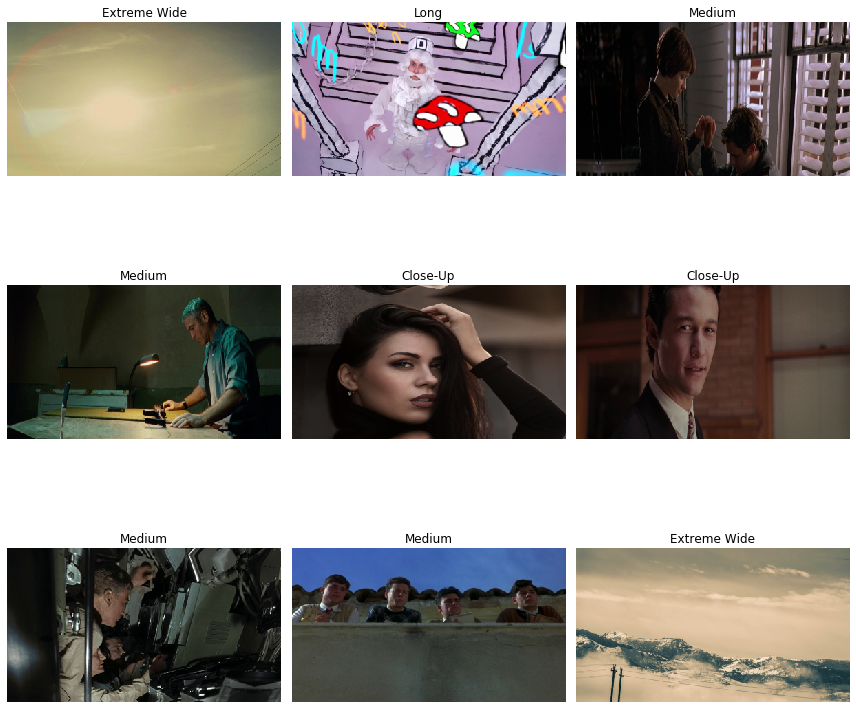

In [ ]:
data = get_data(path, base_size=224, batch_size=32)
data.show_batch(rows=3)
data.classes

In [ ]:
learn = cnn_learner(data, models.mobilenet_v2, pretrained=True,
                    metrics=metrics)

### Training The Head

In [ ]:
model_name = 'MobileNetV2-img_224-frozen'
callbacks  = get_callbacks(learn, model_name)

In [ ]:
#export
def lr_find(**lr_find_args):
    learn.lr_find(**lr_find_args)
    learn.recorder.plot()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


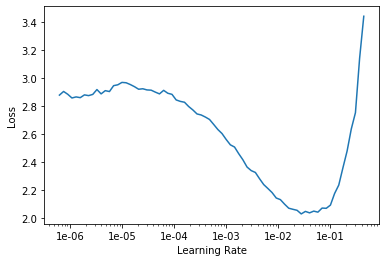

In [ ]:
lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-3, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.223758,0.442421,0.815000,0.816103,0.815000,00:50
1,0.738651,0.335937,0.875000,0.877412,0.875000,00:48
2,0.575809,0.253960,0.900000,0.902538,0.900000,00:47
3,0.424647,0.296663,0.910000,0.919557,0.910000,00:47
4,0.380287,0.228647,0.913333,0.916319,0.913333,00:49
5,0.281996,0.241804,0.926667,0.929314,0.926667,00:49
6,0.243300,0.233967,0.926667,0.927721,0.926667,00:47
7,0.214836,0.207012,0.923333,0.926839,0.923333,00:52
8,0.182585,0.219892,0.918333,0.921445,0.918333,00:48
9,0.176486,0.204732,0.928333,0.931089,0.928333,00:47


Better model found at epoch 0 with accuracy value: 0.8149999976158142.
Better model found at epoch 0 with valid_loss value: 0.44242069125175476.


/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 1 with accuracy value: 0.875.
Better model found at epoch 1 with valid_loss value: 0.33593684434890747.
Better model found at epoch 2 with accuracy value: 0.8999999761581421.
Better model found at epoch 2 with valid_loss value: 0.2539602518081665.
Better model found at epoch 3 with accuracy value: 0.9100000262260437.
Better model found at epoch 4 with accuracy value: 0.9133333563804626.
Better model found at epoch 4 with valid_loss value: 0.2286473661661148.
Better model found at epoch 5 with accuracy value: 0.9266666769981384.
Better model found at epoch 7 with valid_loss value: 0.2070120871067047.
Better model found at epoch 9 with accuracy value: 0.9283333420753479.
Better model found at epoch 9 with valid_loss value: 0.20473173260688782.


In [ ]:
suffix='-opt_accuracy'
learn.load(f'{model_name}{suffix}');

### Interpret

In [ ]:
interpret = ClassificationInterpretation.from_learner(learn)

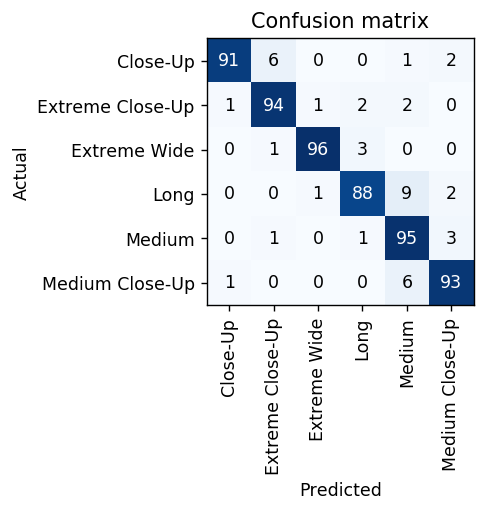

In [ ]:
interpret.plot_confusion_matrix(dpi=125)

### Unfreezing & Fine Tuning

In [ ]:
suffix='-opt_accuracy'
learn.load(f'{model_name}{suffix}');

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


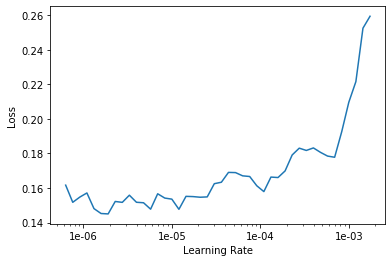

In [ ]:
learn.unfreeze()
lr_find()

In [ ]:
model_name = 'MobileNetV2-img_224-unfrozen'
callbacks  = get_callbacks(learn, model_name, patience=4)

In [ ]:
learn.fit_one_cycle(15, slice(1e-6, 1e-4), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.150490,0.206514,0.918333,0.920812,0.918333,00:48
1,0.155198,0.199978,0.923333,0.923806,0.923333,00:47
2,0.158984,0.185992,0.930000,0.931204,0.930000,00:50
3,0.156985,0.194974,0.928333,0.929127,0.928333,00:50
4,0.159074,0.184189,0.928333,0.929690,0.928333,00:48
5,0.147176,0.181927,0.938333,0.939243,0.938333,00:48
6,0.123227,0.188816,0.926667,0.927587,0.926667,00:47


Better model found at epoch 0 with accuracy value: 0.9183333516120911.
Better model found at epoch 0 with valid_loss value: 0.2065141201019287.
Better model found at epoch 1 with accuracy value: 0.9233333468437195.
Better model found at epoch 1 with valid_loss value: 0.1999778002500534.
Better model found at epoch 2 with accuracy value: 0.9300000071525574.
Better model found at epoch 2 with valid_loss value: 0.18599152565002441.
Better model found at epoch 4 with valid_loss value: 0.18418915569782257.
Better model found at epoch 5 with accuracy value: 0.9383333325386047.
Better model found at epoch 5 with valid_loss value: 0.1819274127483368.
Epoch 7: early stopping


### Interpret

In [ ]:
learn.load(f'{model_name}{suffix}');

In [ ]:
interpret = ClassificationInterpretation.from_learner(learn)

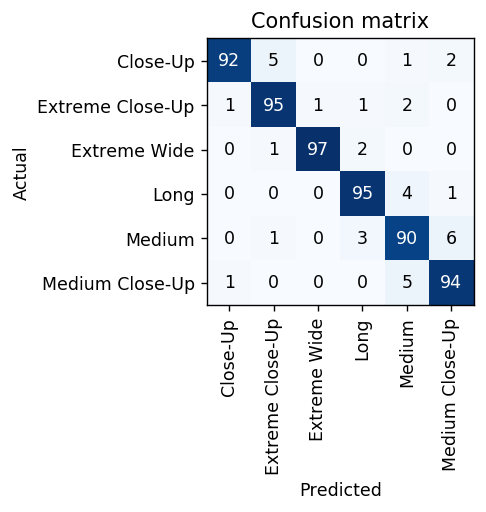

In [ ]:
interpret.plot_confusion_matrix(dpi=125)

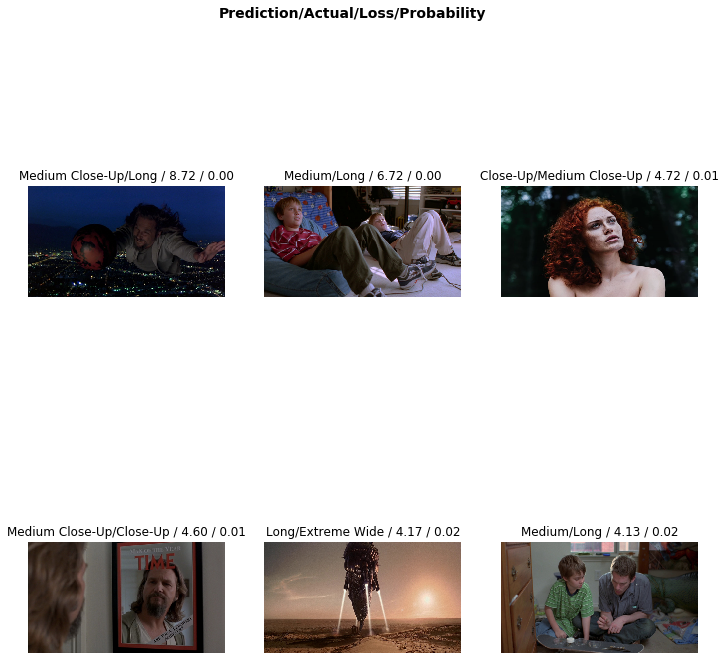

In [ ]:
interpret.plot_top_losses(6)

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 112, 199]       864        True      
______________________________________________________________________
BatchNorm2d          [32, 112, 199]       64         True      
______________________________________________________________________
ReLU6                [32, 112, 199]       0          False     
______________________________________________________________________
Conv2d               [32, 112, 199]       288        True      
______________________________________________________________________
BatchNorm2d          [32, 112, 199]       64         True      
______________________________________________________________________
ReLU6                [32, 112, 199]       0          False     
______________________________________________________________________
Conv2d               [16, 112, 199]       512        True      
___________________________________________________